In [2]:
#Load libraries\n",
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import calendar
from geopy.distance import geodesic
from math import radians, sin, cos, acos
import math
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#Import libraries for LR
import statsmodels.api as sm
import statistics

In [3]:
#Set working directory
os.chdir("E:\EDW\Projects\Cab Fare Prediction")
#os.getcwd()
#'E:\\EDW\\Projects\\Cab Fare Prediction'

In [4]:
#Load Data
cab_data_train = pd.read_csv("train_cab_data.csv")
cab_data_test = pd.read_csv("test_cab_data.csv")

In [5]:

min_longitude = min(min(cab_data_test['pickup_longitude']), min(cab_data_test['dropoff_longitude']))
max_longitude = max(max(cab_data_test['pickup_longitude']), max(cab_data_test['dropoff_longitude']))
min_latitude = min(min(cab_data_test['pickup_latitude']), min(cab_data_test['dropoff_latitude']))
max_latitude = max(max(cab_data_test['pickup_latitude']), max(cab_data_test['dropoff_latitude']))
max_passenger_count = max(cab_data_test['passenger_count'])
min_passenger_count = min(cab_data_test['passenger_count'])

In [6]:
#converting to datetime format
cab_data_train = cab_data_train.sort_values(by = ['pickup_datetime'], ascending = False)
cab_data_train = cab_data_train.iloc[1:]
cab_data_train['pickup_datetime'] = pd.to_datetime(cab_data_train.pickup_datetime, format = '%Y-%m-%d %H:%M:%S UTC')
cab_data_train['fare_amount'] = pd.to_numeric(cab_data_train['fare_amount'], errors='coerce')

#Extrapolating time/day/month details
cab_data_train['pickup_date']= cab_data_train['pickup_datetime'].dt.date
cab_data_train['pickup_day']=cab_data_train['pickup_datetime'].apply(lambda x:x.day)
cab_data_train['pickup_hour']=cab_data_train['pickup_datetime'].apply(lambda x:x.hour)
cab_data_train['pickup_day_of_week']=cab_data_train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
cab_data_train['pickup_month']=cab_data_train['pickup_datetime'].apply(lambda x:x.month)
cab_data_train['pickup_year']=cab_data_train['pickup_datetime'].apply(lambda x:x.year)

#calculate trip distance in Kms
def distance(lat1, lat2, lon1,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 12742 * np.arcsin(np.sqrt(a))

cab_data_train['trip_distance']=cab_data_train.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)

In [7]:
#Missing Values before Outlier removal
missing_value_b = pd.DataFrame(cab_data_train.isnull().sum()).reset_index().rename(columns = {'index' : 'Variable', 0: 'Missing Values'})
missing_value_b['Missing_Percentage'] = (missing_value_b['Missing Values'])/(len(cab_data_train))*100
missing_value_b.sort_values(by = ['Missing Values'], ascending = False)

,Variable,Missing Values,Missing_Percentage
6,passenger_count,55,0.342338
0,fare_amount,25,0.155608
1,pickup_datetime,0,0.000000
2,pickup_longitude,0,0.000000
3,pickup_latitude,0,0.000000
4,dropoff_longitude,0,0.000000
5,dropoff_latitude,0,0.000000
7,pickup_date,0,0.000000
8,pickup_day,0,0.000000
9,pickup_hour,0,0.000000


In [8]:
#removing negligible na values
cab_data_train = cab_data_train.loc[~((cab_data_train.fare_amount.isnull() == True) | (cab_data_train.passenger_count.isnull() == True))]

{'whiskers': [<matplotlib.lines.Line2D at 0x1fefec3add8>,
 'caps': [<matplotlib.lines.Line2D at 0x1fefec1b4a8>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fefec3a9b0>],
 'medians': [<matplotlib.lines.Line2D at 0x1fefec1bb38>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fefec1be80>],
 'means': []}

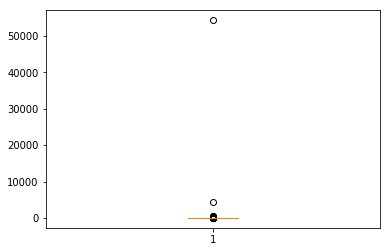

In [9]:
#Plot boxplot to visualize Outliers\n",
%matplotlib inline
plt.boxplot(cab_data_train['fare_amount'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1fe806e98d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1fe806e9f60>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fe806e94e0>],
 'medians': [<matplotlib.lines.Line2D at 0x1fe806e0630>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fe806e0978>],
 'means': []}

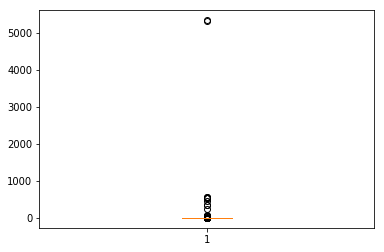

In [10]:
plt.boxplot(cab_data_train['passenger_count'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1fe800b7390>,
 'caps': [<matplotlib.lines.Line2D at 0x1fe800b7a20>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fe800aef60>],
 'medians': [<matplotlib.lines.Line2D at 0x1fe800b7e10>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fe800c0438>],
 'means': []}

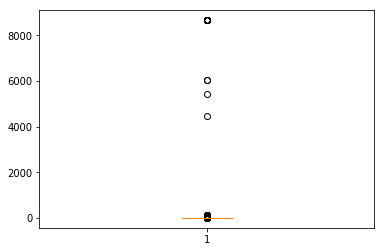

In [11]:
plt.boxplot(cab_data_train['trip_distance'])

In [12]:
#removing Outlier values
cab_data_train = cab_data_train.loc[~((cab_data_train.pickup_latitude==0) | (cab_data_train.pickup_longitude)==0 | (cab_data_train.dropoff_latitude==0)|(cab_data_train.dropoff_longitude==0))]
cab_data_train = cab_data_train.loc[~((cab_data_train['pickup_longitude'] > max_longitude) | (cab_data_train['pickup_longitude'] < min_longitude) |
                    (cab_data_train['pickup_latitude'] > max_latitude) | (cab_data_train['pickup_latitude'] < min_latitude) |
                    (cab_data_train['dropoff_longitude'] > max_longitude) | (cab_data_train['dropoff_longitude'] < min_longitude) |
                    (cab_data_train['dropoff_latitude'] > max_latitude) | (cab_data_train['dropoff_latitude'] < min_latitude))]
cab_data_train = cab_data_train.loc[~((cab_data_train['passenger_count'] > max_passenger_count) | (cab_data_train['passenger_count'] < min_passenger_count))]
cab_data_train = cab_data_train.loc[~(cab_data_train['fare_amount'] < 0)]

#removing negligible na values
cab_data_train = cab_data_train.loc[~((cab_data_train.fare_amount.isnull() == True) | (cab_data_train.passenger_count.isnull() == True))]

In [13]:
#Identifying Outlier values in Fare_amount and removing it
cnames = ["fare_amount", "trip_distance"]

for i in cnames:
    q75, q25 = np.percentile(cab_data_train.loc[:, i], [75 ,25])
    iqr = q75 - q25
    min = q25 - (iqr*1.5)
    max = q75 + (iqr*1.5)
    print(i)
    print(min)
    print(max)

    cab_data_train = cab_data_train.drop(cab_data_train[cab_data_train.loc[:,i] < min].index)
    cab_data_train = cab_data_train.drop(cab_data_train[cab_data_train.loc[:,i] > max].index)

fare_amount
-3.75
22.25
trip_distance
-1.9389169500983117
6.437880907475156


{'whiskers': [<matplotlib.lines.Line2D at 0x1fe80259550>,
 'caps': [<matplotlib.lines.Line2D at 0x1fe80255198>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fe8025bc18>],
 'medians': [<matplotlib.lines.Line2D at 0x1fe80250748>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fe8024ca90>],
 'means': []}

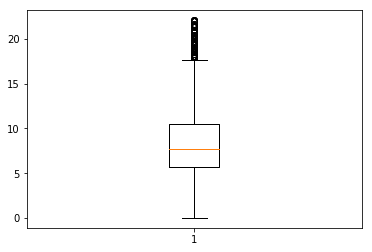

In [14]:
plt.boxplot(cab_data_train['fare_amount'])

{'whiskers': [<matplotlib.lines.Line2D at 0x1fe801dd4a8>,
 'caps': [<matplotlib.lines.Line2D at 0x1fe801d7a20>,
 'boxes': [<matplotlib.lines.Line2D at 0x1fe801ddcc0>],
 'medians': [<matplotlib.lines.Line2D at 0x1fe801d2b70>],
 'fliers': [<matplotlib.lines.Line2D at 0x1fe801cef60>],
 'means': []}

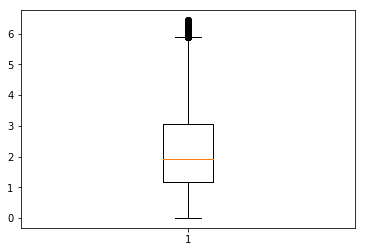

In [15]:
plt.boxplot(cab_data_train['trip_distance'])

In [16]:
#missing_value after removing outliers
missing_value_b = pd.DataFrame(cab_data_train.isnull().sum()).reset_index().rename(columns = {'index' : 'Variable', 0: 'Missing Values'})
missing_value_b['Missing_Percentage'] = (missing_value_b['Missing Values'])/(len(cab_data_train))*100
missing_value_b.sort_values(by = ['Missing Values'], ascending = False)

,Variable,Missing Values,Missing_Percentage
0,fare_amount,0,0.0
1,pickup_datetime,0,0.0
2,pickup_longitude,0,0.0
3,pickup_latitude,0,0.0
4,dropoff_longitude,0,0.0
5,dropoff_latitude,0,0.0
6,passenger_count,0,0.0
7,pickup_date,0,0.0
8,pickup_day,0,0.0
9,pickup_hour,0,0.0


In [17]:
# Convert Object field of Weekday to Numeric 
# creating a dict file  
weekday = {'Sunday': 0,'Monday': 1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5, 'Saturday':6} 

cab_data_train.pickup_day_of_week = [weekday[item] for item in cab_data_train.pickup_day_of_week]

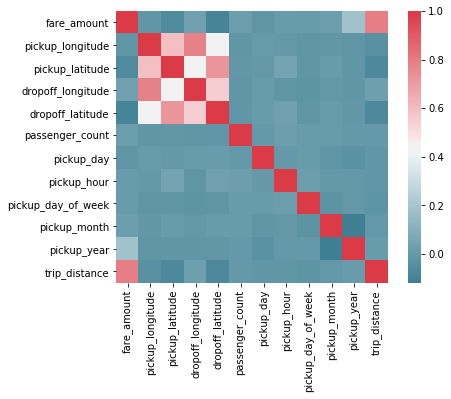

In [18]:
##Correlation analysis
#Correlation plot
df_corr = cab_data_train.loc[:,:]

#Set the width and hieght of the plot
f, ax = plt.subplots(figsize=(7, 5))
#Generate correlation matrix
corr = df_corr.corr()

#Plot using seaborn library\n",
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax)


In [26]:
"""

#Chisquare test of independence
#Save categorical variables
from scipy.stats import chi2_contingency

#loop for chi square values
for i in cab_data_train.columns:
    print(i)
    chi2, p, dof, ex = chi2_contingency(pd.crosstab(cab_data_train['fare_amount'], cab_data_train[i]))
    print(p)
    if p < 0.05:
        print(i, "Variable used for predicting")
"""

'\n\n#Chisquare test of independence\n#Save categorical variables\nfrom scipy.stats import chi2_contingency\n\n#loop for chi square values\nfor i in cab_data_train.columns:\n    print(i)\n    chi2, p, dof, ex = chi2_contingency(pd.crosstab(cab_data_train[\'fare_amount\'], cab_data_train[i]))\n    print(p)\n    if p < 0.05:\n        print(i, "Variable used for predicting")\n'

In [19]:
cab_data_train.columns
cab_data_train = cab_data_train[['fare_amount', 'pickup_longitude', 'pickup_latitude', 'passenger_count', 'pickup_day', 'pickup_hour', 'pickup_day_of_week',
       'pickup_month', 'pickup_year', 'trip_distance']]

In [20]:
cab_data_test['fare_amount'] = 0
cab_data_test['pickup_datetime'] = pd.to_datetime(cab_data_test.pickup_datetime, format = '%Y-%m-%d %H:%M:%S UTC')
cab_data_test['fare_amount'] = pd.to_numeric(cab_data_test['fare_amount'], errors='coerce')

#Extrapolating time/day/month details
cab_data_test['pickup_date']= cab_data_test['pickup_datetime'].dt.date
cab_data_test['pickup_day']=cab_data_test['pickup_datetime'].apply(lambda x:x.day)
cab_data_test['pickup_hour']=cab_data_test['pickup_datetime'].apply(lambda x:x.hour)
cab_data_test['pickup_day_of_week']=cab_data_test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
cab_data_test['pickup_month']=cab_data_test['pickup_datetime'].apply(lambda x:x.month)
cab_data_test['pickup_year']=cab_data_test['pickup_datetime'].apply(lambda x:x.year)

#calculate trip distance in Kms
def distance(lat1, lat2, lon1,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 12742 * np.arcsin(np.sqrt(a))

cab_data_test['trip_distance']=cab_data_test.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)

In [21]:
cab_data_test = cab_data_test[['fare_amount', 'pickup_longitude', 'pickup_latitude', 'passenger_count', 'pickup_day', 'pickup_hour', 'pickup_day_of_week',
       'pickup_month', 'pickup_year', 'trip_distance']]

In [22]:

#Divide data into train and test
train, test = train_test_split(cab_data_train, test_size=0.3)


In [23]:
#######################################################################################################################

#Decision tree for regression
fit_DT = DecisionTreeRegressor(max_depth=2).fit(train.iloc[:,1:10], train.iloc[:,0])

#Apply model on test data
predictions_DT = fit_DT.predict(test.iloc[:,1:10])


#Calculate RMSE
def RMSE(y_true, y_pred): 
    rmse = math.sqrt(statistics.mean((y_true - y_pred)**2))
    return rmse

DT_RMSE = RMSE(test.iloc[:,0], predictions_DT)
print("RMSE  - Decision tree", DT_RMSE)


RMSE  - Decision tree 2.35907410834951


In [31]:

#Random Forest for regression
fit_RF = RandomForestRegressor(bootstrap=True, max_depth=4, random_state=0 ,n_estimators=50).fit(train.iloc[:,1:10], train.iloc[:,0])

#Apply model on test data
predictions_RF = fit_RF.predict(test.iloc[:,1:10])

RF_RMSE = RMSE(test.iloc[:,0], predictions_RF)
print("RMSE - Random Forest", RF_RMSE)

RMSE - Random Forest 2.090953636512424


In [26]:

# Train the model using the training sets
linear_model = sm.OLS(train.iloc[:,0], train.iloc[:,1:10]).fit()

# Print out the statistics
linear_model.summary()

# make the predictions by the model
predictions_LR = linear_model.predict(test.iloc[:,1:10]) 


#Calculate MAPE
LR_RMSE = RMSE(test.iloc[:,0], predictions_LR)
print("RMSE - Linear Regression ", LR_RMSE)

RMSE - Linear Regression  2.1408181209253416


In [27]:
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            fare_amount   R-squared:                       0.946
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                 1.849e+04
Date:                Sun, 19 May 2019   Prob (F-statistic):               0.00
Time:                        17:47:43   Log-Likelihood:                -20787.
No. Observations:                9500   AIC:                         4.159e+04
Df Residuals:                    9491   BIC:                         4.166e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
pickup_longitude       7.1068      0.401     17.743      0.000       6.322       7.892
pickup_latitude       -4.8223      0.633     -7.615      0.000      -6.064      -3.581
passenger_count        0.0421      0.018      2.396      0.017       0.008       0.077
pickup_day            -0.0022      0.003     -0.880      0.379      -0.007       0.003
pickup_hour            0.0121      0.003      3.499      0.000       0.005       0.019
pickup_day_of_week     0.0514      0.011      4.638      0.000       0.030       0.073
pickup_month           0.0528      0.006      8.167      0.000       0.040       0.066
pickup_year            0.3606      0.012     30.889      0.000       0.338       0.384
trip_distance          2.0382      0.016    131.421      0.000       2.008       2.069
==============================================================================
Omnibus:                     2908.498   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12097.707
Skew:                           1.459   Prob(JB):                         0.00
Kurtosis:                       7.696   Cond. No.                     6.33e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.33e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""